# Project: Data Analysis of 2016 Mental Health Survey Data in Tech.
## by Daniel Leirer

## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#set&lib">Settings and Libraries</a></li>
<li><a href="#clean">Clean Data</a></li>
<li><a href="#analysis">Analysis</a></li>
<li><a href="#multivar">Multivariate Exploration</a></li>
</ul>

<a id='intro'></a>

## Introduction

This is an exploratory analysis of the 2016 Mental Health Survey Data in Tech. The data used here is available at  https://osmihelp.org/research.

I choose to focuse on the 2016 data since that year they got the largest number of responses (a total of 1433).


The questions that I am aiming to explore here are as follows:


1. What Mental Health disorders are common in Tech? 

2. How much of an impact do Mental Health disorders have on productivity?

3. Are companies providing resources or benefits to their workers?



<a id="set&lib"></a>
    
## Settings & Libraries:


### Import Packages


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
## set sns basecolor
base_color = sns.color_palette()[0]

#magic for matplotlib
%matplotlib inline

#make data folder
data_dir = "data"

### Get Survey data
Read CSV data.

In [2]:
#Paths to files
MHS_2016_Path = os.path.join(data_dir,"mental-heath-in-tech-2016_20161114.csv")

#Load Data
df_mhs_core = pd.read_csv(MHS_2016_Path, sep=",")

<a id="clean"></a>
## Clean Data



### Clean Columns
The first issue with this data is that the column names are the survey questions. 
The first step will be to replace create new column names, and to create a dictionary that maps the old columns to the new ones. 


1. Create dictionary for columns. 
2. Turn dictionary to dataframe and save. 
3. Replace column names with new column ids. 

In [4]:
## create new 2016 data columns
columns_2016 = ['Selfemployed',
       'Company_size',
       'Company_tech',
       'Company_role_tech',
       'Company_MH_benefits',
       'Company_MH_benefits_options_aware',
       'Company_MH_benefits_discussed',
       'Company_MH_resources',
       'Company_MH_resources_anonymous',
       'Company_MH_medical_leave_ease',
       'Employer_MH_discuss_neg',
       'Employer_PH_discuss_neg',
       'MH_discuss_willing_coworker',
       'MH_discuss_willing_supervisor',
       'Company_MH_vs_PH',
       'MH_neg_outcome_coworker',
       'MH_insurance',
       'MH_online_resources_known',
       'MH_reveal_clients',
       'MH_revealed_neg',
       'MH_reveal_coworkers',
       'MH_reveal_neg',
       'MH_productivity',
       'MH_productivity_percent_affected',
       'PE_Previous_employer_exist',
       'PE_MH_benefits',
       'PE_MH_benefits_options_aware',
       'PE_MH_benefits_discussed',
       'PE_MH_resources',
       'PE_MH_resources_anonymous',
       'PE_MH_discuss_neg',
       'PE_PH_discuss_neg',
       'PE_MH_discuss_willing_coworker',
       'PE_MH_discuss_willing_supervisor',
       'PE_MH_vs_PH',
       'PE_MH_neg_outcome_coworker',
       'PH_interview_reveal',
       'PH_interview_reveal_why',
       'MH_interview_reveal',
       'MH_interview_reveal_why',
       'MH_reveal_hurt_career',
       'MH_reveal_coworkers_neg',
       'MH_willing_share_friends',
       'Company_MH_badly_handled',
       'MH_others_neg_affect_own',
       'MH_family_history',
       'MH_previous',
       'MH_current',
       'MH_current_yes',
       'MH_current_maybe',
       'MH_diagnosed_professional',
       'MH_diagnosed_conditions',
       'MH_treatment_professional',
       'MH_work_intereference_treated',
       'MH_work_intereference_untreated',
       'Age', 'Gender',
       'Country_live',
       'US_state_live',
       'Country_work',
       'US_state_work',
       'Work_position',
       'Work_remote']

             

In [5]:
## Create dictionary dataframe for 2016 questions
df_2016_questions = pd.DataFrame( {"Column_id" : columns_2016 , "Question" : df_mhs_core.columns.values }) 

## Change dataframe columns to new columns
df_mhs_core.columns = df_2016_questions.Column_id

In [6]:
#Function to set index and User_ID
def make_user_index(input_df,survey_year):
    '''
    Function to make unique user Ids and index.
    Input = 
    Dataframe of survey data
    Year of survey
    Output = 
    Dataframe with year column and index added. 
    '''
    #add column for year of survey
    input_df["Year"] = survey_year
    #Add userid column
    input_df["User_ID"] = range(len(input_df))
    #Expand userid to make it a better identifer
    input_df["User_ID"] = "User_"+input_df.User_ID.astype(str) +"_"+input_df.Year.astype(str)
    #setIndex
    input_df.set_index(input_df["User_ID"],inplace=True)
    return (input_df)

In [7]:
df_mhs_core = make_user_index(df_mhs_core,2016)

<a id="set&lib"></a>

## Analysis:



### 1. What Mental Health Disorders are common for people in tech?

The first question to anwser is about the frequency of the types of mental illness in tech. 
The first thing to look at is how many people in the survey had a mental health condition in the past or currently have one. For that I will look at the 'MH_previous' and current columns 'MH_current'.

Then I will focus on individuals who have been officially diagnosed.

Since individuals can have multiple conditions I want to seperate them into new columns. 
For this I will create a new column for each condition. 

I also want a feature for comorbidity. This is the number of cooccuring conditions.

In [8]:
#make countplot with percentage values
def make_countplot_per(input_df,x_var,x_label,cat_order,color=base_color):
    '''
    Function to make Seaborn countplot with percentages. 
    Input = 
    dataframe,
    x_variable,
    x_label
    cat_order = order of categoricals. 
    Output = 
    seaborn countplot with percentages.
    '''
    p_pre = sns.countplot(data=input_df,x=x_var,order=cat_order,color=color)
    plt.xlabel(x_label)

    cat_counts = input_df[x_var].value_counts()
    n_points = cat_counts.sum()
    locs, labels = plt.xticks() # get the current tick locations and labels

    # loop through each pair of locations and labels
    for loc,label in zip(locs, labels):
    
        # get the text property for the label to get the correct count
        count = cat_counts[label.get_text()]
        percentage = 100*count/n_points
        pct_string = '{:0.1f}%'.format(percentage)
        
        if percentage > 10:
            # print the annotation just below the top of the bar
            plt.text(loc,count-30, pct_string, ha = 'center', color = 'w')
        else:
            # print the annotation just above the top of the bar
            plt.text(loc,count+30, pct_string, ha = 'center', color = 'b')

#get survey question
def survey_q(Q_ID, df_2016_questions=df_2016_questions):
    '''
    #get survey question
    Input =
    Q_ID (the survey question ID)
    df_2016_questions (dataframe of questions)
    Output = 
    Original survey question. 
    '''
    output = df_2016_questions[df_2016_questions.Column_id == Q_ID].Question.values[0]
    return (output)


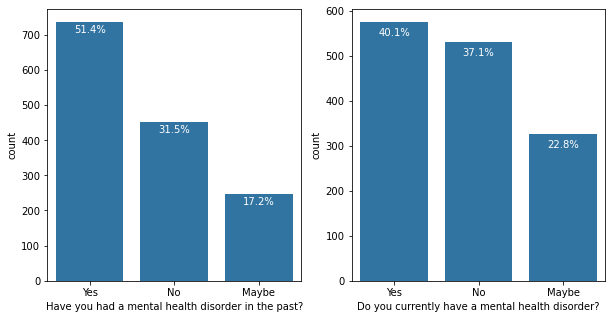

In [9]:
#set category order
cat_order=("Yes","No","Maybe")

plt.figure(figsize = [10,5 ])

## left plot
plt.subplot(1,2, 1)

#set variables
x_var="MH_previous"
x_label=survey_q(x_var)
#x_label="Previously had a Mental Health condition?"

#make countplot
make_countplot_per(input_df=df_mhs_core,x_var=x_var,x_label=x_label,cat_order=cat_order)


## right plot
plt.subplot(1,2, 2)

#set variables
x_var="MH_current"
x_label=survey_q(x_var)
#make countplot
make_countplot_per(input_df=df_mhs_core,x_var=x_var,x_label=x_label,cat_order=cat_order)



In the survey respondants more than half (51.4%) say they have previously been diagnosed with a mental health condition, and an additional 17.2% say they may have had a mental health condition.

And a total of 62.9% say they currently have or may have a condition. 

In [10]:
## Mental Health Categories clean. 

#Add Columns for mental health disorders. 
Mental_health_old_cats = ["Anxiety Disorder (Generalized, Social, Phobia, etc)","Mood Disorder (Depression, Bipolar Disorder, etc)","Psychotic Disorder (Schizophrenia, Schizoaffective, etc)","Eating Disorder (Anorexia, Bulimia, etc)","Attention Deficit Hyperactivity Disorder","Personality Disorder (Borderline, Antisocial, Paranoid, etc)","Obsessive-Compulsive Disorder","Post-traumatic Stress Disorder","Stress Response Syndromes","Dissociative Disorder","Substance Use Disorder","Addictive Disorder","Other"]
Mental_health_new_cats = ["Anxiety","Mood","Psychotic","Eating","ADHD","Personality","OCD","PTSD","Stress_response","Dissociative","Substance_use","Addictive","Other"]


#loop through mental health categories, and add to columns if found. 
for i in range(len(Mental_health_old_cats)):
    #find mental health conditions in diagnosed conditions professional column. 
    mh_cat_finder=df_mhs_core.MH_diagnosed_conditions.str.contains(Mental_health_old_cats[i],regex=False)
    #subset to rows where old category was found, and the new column where it should be. Write Yes.
    df_mhs_core.loc[mh_cat_finder == True,Mental_health_new_cats[i]] = "Yes"

# Count number of condition to get comorbidity
df_mhs_core["comorbidity"] = df_mhs_core[Mental_health_new_cats].isin(["Yes"]).sum(axis=1)

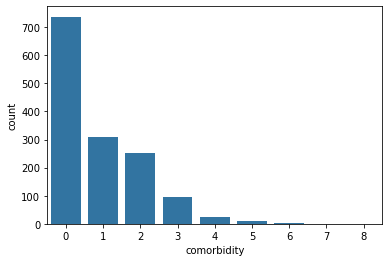

In [11]:
#Countplot of comorbidity
sns.countplot(x="comorbidity" ,data = df_mhs_core,color = base_color);

In [12]:
## number of people that have 1 or more condition.
n_people_mh = df_mhs_core[df_mhs_core.comorbidity != 0].shape[0]
print("individuals with at least 1 condition: ", n_people_mh)
n_people_mh_2 = df_mhs_core[df_mhs_core.comorbidity > 1].shape[0]
print("individuals with at least 2 condition: ", n_people_mh_2)
print("Percentage of individuals with 2 or more conditions", n_people_mh_2 / n_people_mh)

individuals with at least 1 condition:  696
individuals with at least 2 condition:  386
Percentage of individuals with 2 or more conditions 0.5545977011494253


A total of 696 people were diagnosed with at least 1 condition, and 386 of these had 2 or more conditions. 
That means ~ 55% of people with a mental health condition had 2 or more. 

              index  Count  Proportion
0              Mood    526    0.755747
1           Anxiety    373    0.535920
2              ADHD    134    0.192529
3              PTSD     70    0.100575
4               OCD     40    0.057471
5   Stress_response     31    0.044540
6       Personality     28    0.040230
7     Substance_use     26    0.037356
8            Eating     18    0.025862
9         Addictive     15    0.021552
10     Dissociative     10    0.014368
11        Psychotic      8    0.011494


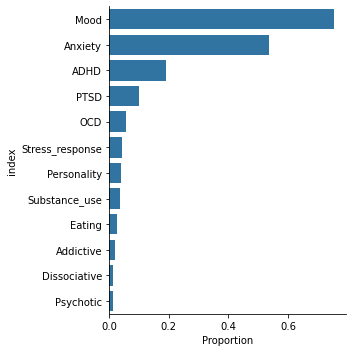

In [13]:
## Melt df by mental health categories.
df_mental_health=pd.melt(df_mhs_core,id_vars=["User_ID","comorbidity"],value_vars=Mental_health_new_cats,var_name="condition")

#sns.countplot(x="condition",data=df_mental_health.dropna())



df_mh_count=df_mental_health.dropna().condition.value_counts(normalize=False).rename("Count").reset_index()

#calculate proprotion of people with mental illness who have each condition. 
df_mh_count["Proportion"] = df_mh_count["Count"] / n_people_mh 
print(df_mh_count)


sns.catplot(data=df_mh_count, y="index", x="Proportion", kind='bar',legend=False,color = base_color);

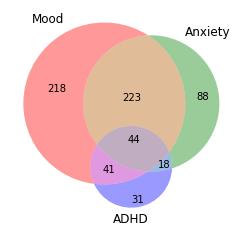

In [14]:
### Make venn diagram of overlap for 3 most common conditions
# select mental health conditions.
mh_conditions=["Mood","Anxiety","ADHD"]


#create list of sets of user ids for venn diagram.
list_of_sets = []
for mh_condition in mh_conditions:
     list_of_sets.append(set(df_mhs_core[df_mhs_core[mh_condition] == "Yes"].User_ID))

#make venn diagram
venn3(list_of_sets,mh_conditions)
plt.show()

Out of the people who said they had a diagnosed mental health condition 75% said they had a Mood condition, 53% said they had an Anxiety condition and 19% said they had ADHD. 

The least common conditions were Psychotic, Addictive and Dissociative disorders 

The 3 most common conditions overlap a lot. Out of 526 individuals with mood disorders 223 also had anxiety, 41 had ADHD and 44 had all three conditions. 

### 2.1 How much of an impact do Mental Health disorders have on productivity?

To understand the impact Mental health disorders have on productivity we can look at the self reported work interference when MH conditions are treated and untreated. 
The columns for this are: (MH_work_intereference_treated,MH_work_intereference_untreated)

Lets first look at the columns to see if they need to be cleaned.

In [15]:
productivity_columns=["MH_work_intereference_treated","MH_work_intereference_untreated"]

#check for mising values. 
for pro_col in productivity_columns:
        print("Missing values: ",df_mhs_core[pro_col].isna().value_counts())
        print("Get value_counts:",df_mhs_core[pro_col].value_counts())


Missing values:  False    1433
Name: MH_work_intereference_treated, dtype: int64
Get value_counts: Not applicable to me    557
Sometimes               369
Rarely                  322
Never                   120
Often                    65
Name: MH_work_intereference_treated, dtype: int64
Missing values:  False    1433
Name: MH_work_intereference_untreated, dtype: int64
Get value_counts: Often                   538
Not applicable to me    468
Sometimes               363
Rarely                   52
Never                    12
Name: MH_work_intereference_untreated, dtype: int64


In [16]:
#subset to values other than not applicable to me. 
df_mh_pro = df_mhs_core[df_mhs_core[productivity_columns[0]]!="Not applicable to me"]
df_mh_pro = df_mh_pro[df_mh_pro[productivity_columns[1]]!="Not applicable to me"]

In [17]:
df_mh_pro.MH_work_intereference_treated.value_counts()

Sometimes    360
Rarely       317
Never        119
Often         64
Name: MH_work_intereference_treated, dtype: int64

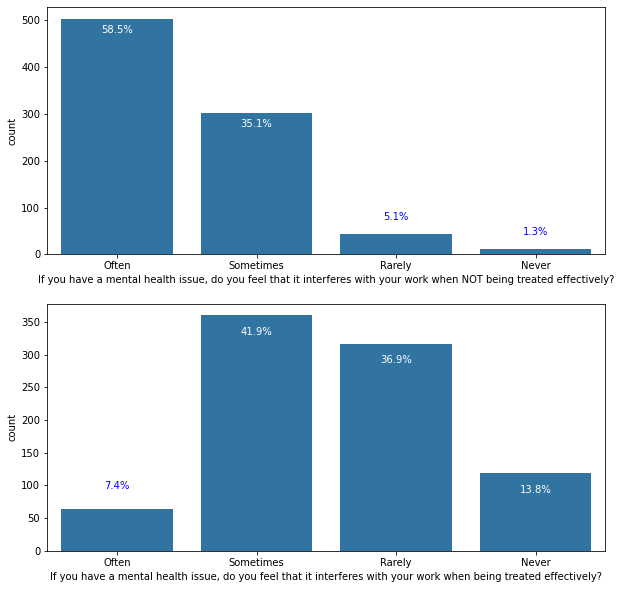

In [18]:
#make countplots for work interference
cat_order = ["Often","Sometimes","Rarely","Never"]
plt.figure(figsize = [10,10 ])

## left plot
plt.subplot(2,1, 1)

#set variables

x_var="MH_work_intereference_untreated"
x_label=survey_q(x_var)

#make countplot
make_countplot_per(input_df=df_mh_pro,x_var=x_var,x_label=x_label,cat_order=cat_order)


## right plot
plt.subplot(2,1, 2)

#set variables
x_var="MH_work_intereference_treated"
x_label=survey_q(x_var)

#make countplot
make_countplot_per(input_df=df_mh_pro,x_var=x_var,x_label=x_label,cat_order=cat_order)

A whooping 93.6% of respondendts said that their mental health condition interfered sometimes of often with their work.
While 6.4% said it rarely or never interefered. 

For people who recieve treatment 50.7% said their mental health condition now rarely or never interefered with their work. 


### 2.2 What conditions see the biggest benefit when effectively treated. 

Select people Anxiety, Mood or ADHD but no comorbidities.
For these three populations plot frequency of being affected by work. 


In [19]:
#melt dataframe on mh conditions. 
MH_variables=["Anxiety","Mood","ADHD"]
id_variables=["User_ID","comorbidity","MH_work_intereference_untreated","MH_work_intereference_treated"]
df_mh_pro_melt = pd.melt(df_mh_pro,id_vars=id_variables,value_vars=MH_variables,var_name="condition")
# remove missing values and subset to comorbidity == 1
df_mh_pro_melt=df_mh_pro_melt.dropna()
df_mh_pro_melt=df_mh_pro_melt[df_mh_pro_melt["comorbidity"] == 1]


#melt again on treated vs untreated. 
#df_mh_pro_melt
id_variables=["User_ID","condition"]
tr_variables=["MH_work_intereference_untreated","MH_work_intereference_treated"]
temp=pd.melt(df_mh_pro_melt,id_vars=id_variables,value_vars=tr_variables,var_name="treatment")

#groupby mh condition and treatment, and calculate percentage for each group. 
temp_vc=temp.groupby(["condition","treatment"]).value.value_counts(normalize=True).rename("Proportion").reset_index()

#replace Tr variables with treated and untreated for plot. 
temp_vc.treatment.replace(tr_variables,["Untreated","Treated"],inplace=True)

temp_vc

,condition,treatment,value,Proportion
0,ADHD,Treated,Rarely,0.360000
1,ADHD,Treated,Sometimes,0.360000
2,ADHD,Treated,Often,0.200000
3,ADHD,Treated,Never,0.080000
4,ADHD,Untreated,Often,0.720000
5,ADHD,Untreated,Sometimes,0.200000
6,ADHD,Untreated,Rarely,0.080000
7,Anxiety,Treated,Rarely,0.379310
8,Anxiety,Treated,Sometimes,0.379310
9,Anxiety,Treated,Never,0.206897


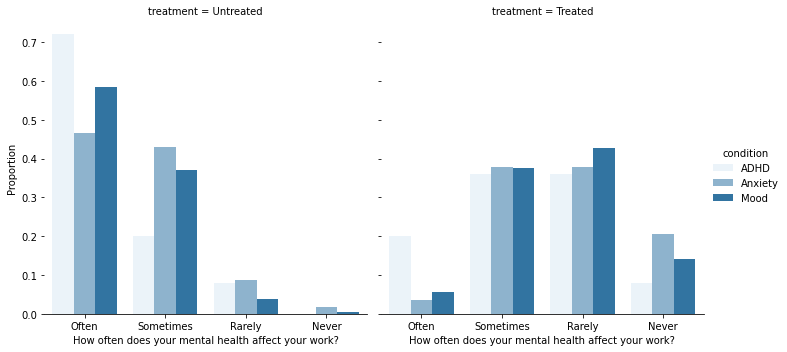

In [20]:
#plot percentage 
g=sns.catplot(data=temp_vc, x="value", y="Proportion",hue="condition",
                col="treatment", kind='bar',order=cat_order,col_wrap=2,
                col_order=["Untreated","Treated"],hue_order=["ADHD","Anxiety","Mood"],
                sharex=True,sharey=True,color = base_color,legend=True)

(g.set_axis_labels("How often does your mental health affect your work?")
   .despine(left=True)) 

For people with just a single condition, it seems that ADHD is the condition that most frequently affects work performance, with over 70% saying they feel it affects them often. 

For Anxiety and Mood disorder these numbers are 46% and 58% respectively. 

It should be noted that this is not an indication of severity. 
People with anxiety might be rarely affected at work, but if they havea severe panic attack it could be very disruptive.


### 3. Are companies providing mental health benfits to their workers?
For this exploration I first want to see what size companies provide benfits that their emplooyees are aware of. 
For this I want to use the columns 'Company_size' and 'Company_MH_benefits'

Following this I want to see if having company mental health benefits affects if employees feel disclosing a mental health condition would have negative consequences for their career. 
for this I will use the 'Employer_MH_discuss_neg' column.


First step is to clean the 3 columns. 

In [21]:
#### Cleaning variables. 
#Clean company size
df_mhs_core.Company_size.replace("More than 1000","1000+",inplace=True)
df_mhs_core.Company_size=df_mhs_core.Company_size.astype('category').cat.set_categories(["1-5", "6-25", "26-100", "100-500", "500-1000", "1000+"], ordered=True)

#Clean Company Benefits
df_mhs_core.Company_MH_benefits.replace('Not eligible for coverage / N/A',np.nan,inplace=True)
df_mhs_core.Company_MH_benefits.replace("I don't know","Unsure",inplace=True)



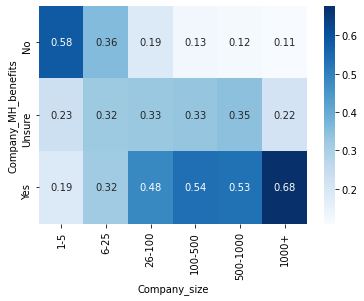

In [26]:
#Make crosstab for company benefits and size. normalize and plot on heatmap. 
ct_norm=pd.crosstab(df_mhs_core["Company_MH_benefits"],df_mhs_core["Company_size"],normalize="columns")
g = sns.heatmap(ct_norm, cmap="Blues", annot=True, cbar=True);


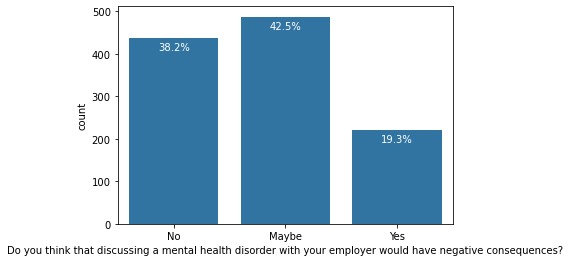

In [68]:
## Plot countplot of Discussing mental health with employer. 

x_var="Employer_MH_discuss_neg"
x_label=survey_q(x_var)
cat_order=["No","Maybe","Yes"]


make_countplot_per(input_df=df_mhs_core,x_var=x_var,x_label=x_label,cat_order=cat_order)


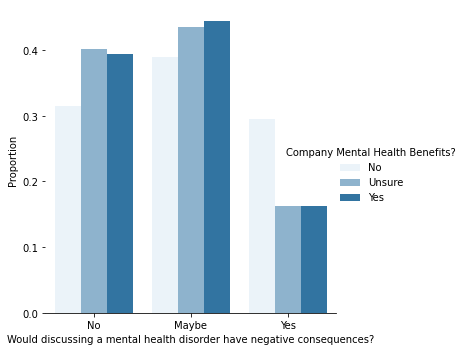

In [77]:
#bar blot of company mental health benefits vs negative consequences. 

df_reac_neg=df_mhs_core.groupby("Company_MH_benefits")["Employer_MH_discuss_neg"].value_counts(normalize=True).rename("Proportion").reset_index()

g = sns.catplot(data=df_reac_neg, x="Employer_MH_discuss_neg", y="Proportion", hue="Company_MH_benefits", kind='bar',
                color = base_color,order=["No","Maybe","Yes"],legend=True)
g._legend.set_title("Company Mental Health Benefits?")
(g.set_axis_labels("Would discussing a mental health disorder have negative consequences?","Proportion")
   .despine(left=True)) ;
#g.set_xticklabels(["No","Potentially Negative","Yes, Negative"])

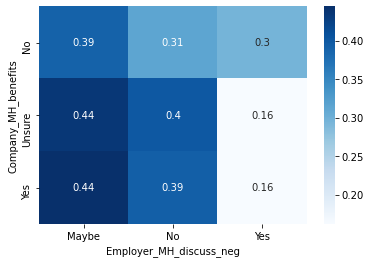

In [73]:
## Crosstab heatmap of company benefits vs negative consequences. 

ct_ben_dis=pd.crosstab(df_mhs_core["Company_MH_benefits"],df_mhs_core["Employer_MH_discuss_neg"],normalize="index")
g = sns.heatmap(ct_ben_dis, cmap="Blues", annot=True, cbar=True);


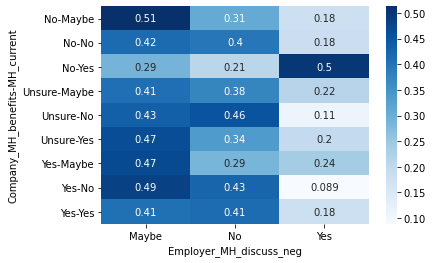

In [79]:


ct_ben_dis=pd.crosstab([df_mhs_core["Company_MH_benefits"],df_mhs_core["MH_current"]],df_mhs_core["Employer_MH_discuss_neg"],normalize="index")
g = sns.heatmap(ct_ben_dis, cmap="Blues", annot=True, cbar=True);


The above plots show that larger companies in general tend to be more liekly to provide mental health benefits. 
Only 19% of companies with 1-5 employees have mental health benefits, while 68% of companies with 1000+ employees have them. 
This makes sense since startups would not have that infrastructure in place. 

A main question would be if companies that have Mental Health Benefits actually improve mental health for individuals. 
The survey data makes that difficult to say, but we can look at the willingness of employees to speak to their employer about their mental health. 

For this we can see if employees feel that discussing a mental health disorder would have negative consequences. 
19.3% of employees feel that it would result in negative consequences. 

When we break this down by whether or not a company provides mental health benefits, we can see that for companies that do not provide mental health benefits, 30% of respondents think that it would lead to negative consequences to discuss their mental health. 

On the other hand for employees that either know their company provides mental health benefits, or are unsure, only 16% feel that discussing their mental health would have negative consequences. 